Loading data...

Class Distribution:
0       18
1        7
2        7
3       65
4      238
5     4479
6      553
7      103
8      516
9       25
10    1081
11      78
12     457
13      62
14     264
15      26
16       6
17     354
18      60
19     177
20     153
21     269
22       7
23      41
24     385
25     184
26     278
27     107
Name: count, dtype: int64
Minority Class: 16

Standardizing features...

                 MODEL COMPARISON                 

Evaluating Random Forest...


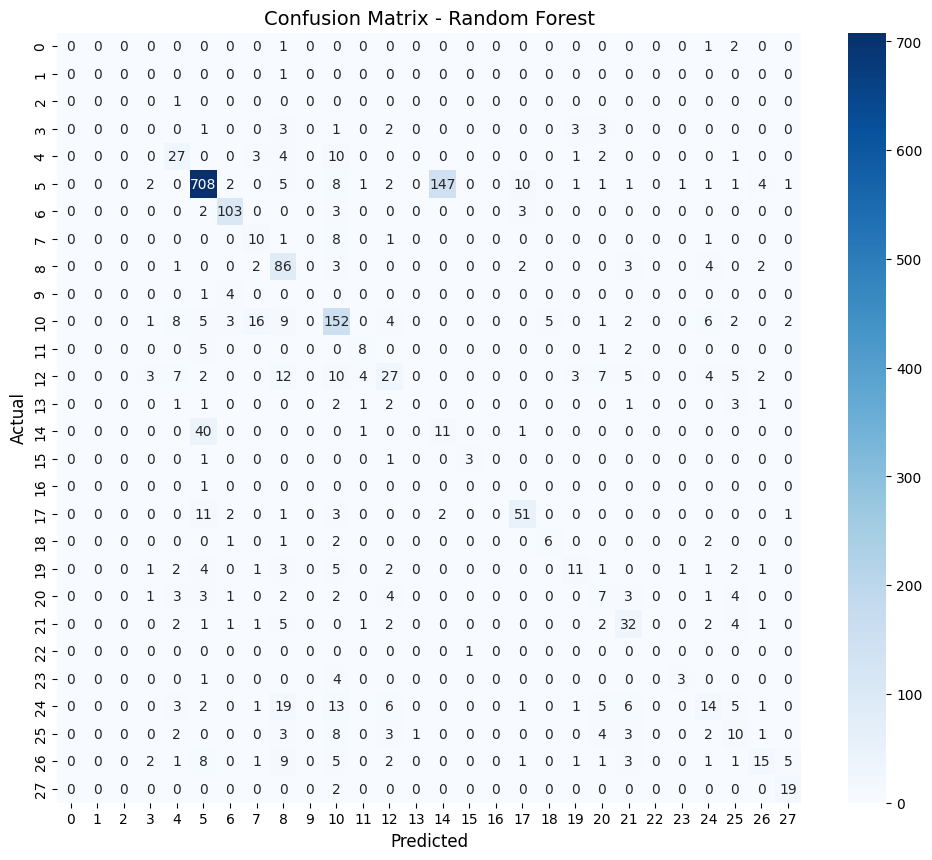

Macro F1: 0.3590
Weighted F1: 0.6588
Minority Class F1: 0.0000

Evaluating Balanced RF...


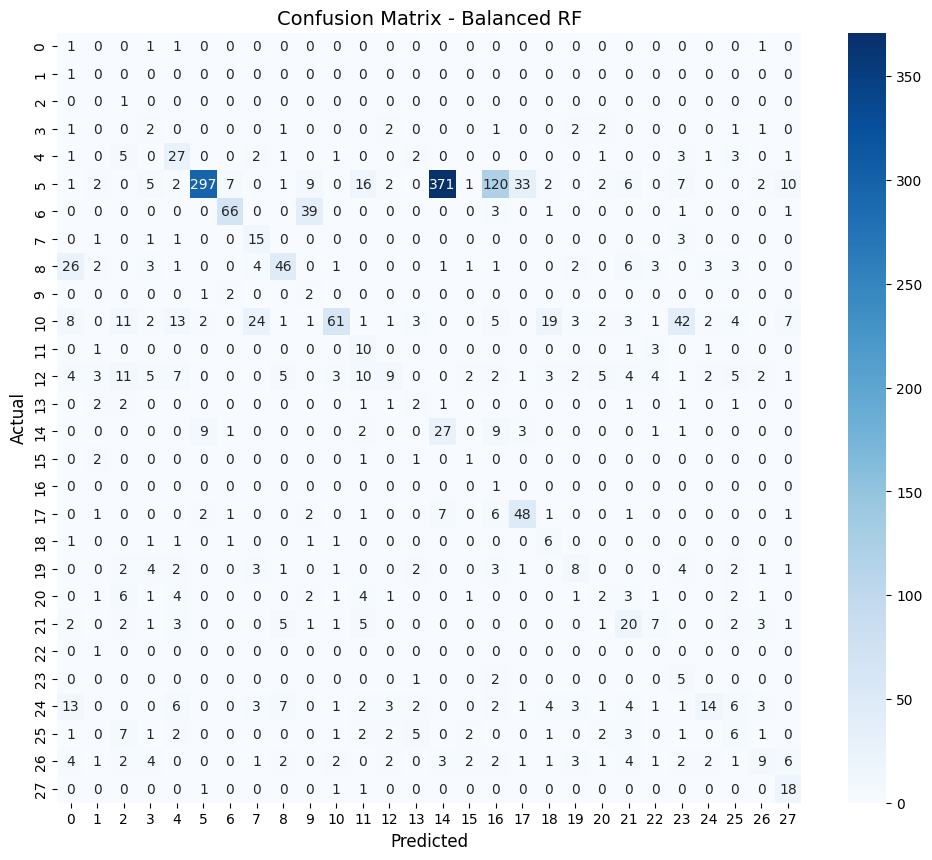

Macro F1: 0.2480
Weighted F1: 0.4261
Minority Class F1: 0.0127

Evaluating XGBoost...


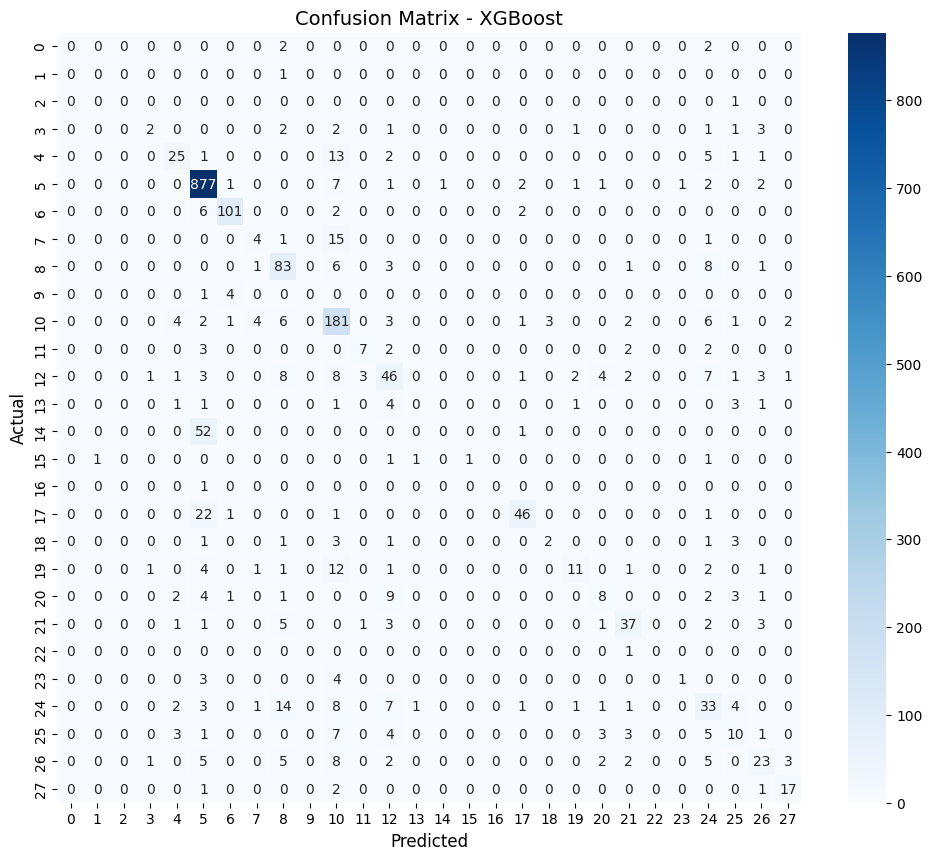

Macro F1: 0.3665
Weighted F1: 0.7308
Minority Class F1: 0.0000

Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 300
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training from score -3.332204
[LightGBM] [Info] Start training from score -3.332204
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training from score -3.332204
[LightGBM] [Info] Start training from score -3.332204
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training from score -3.332204
[LightGBM] [Info] Start train

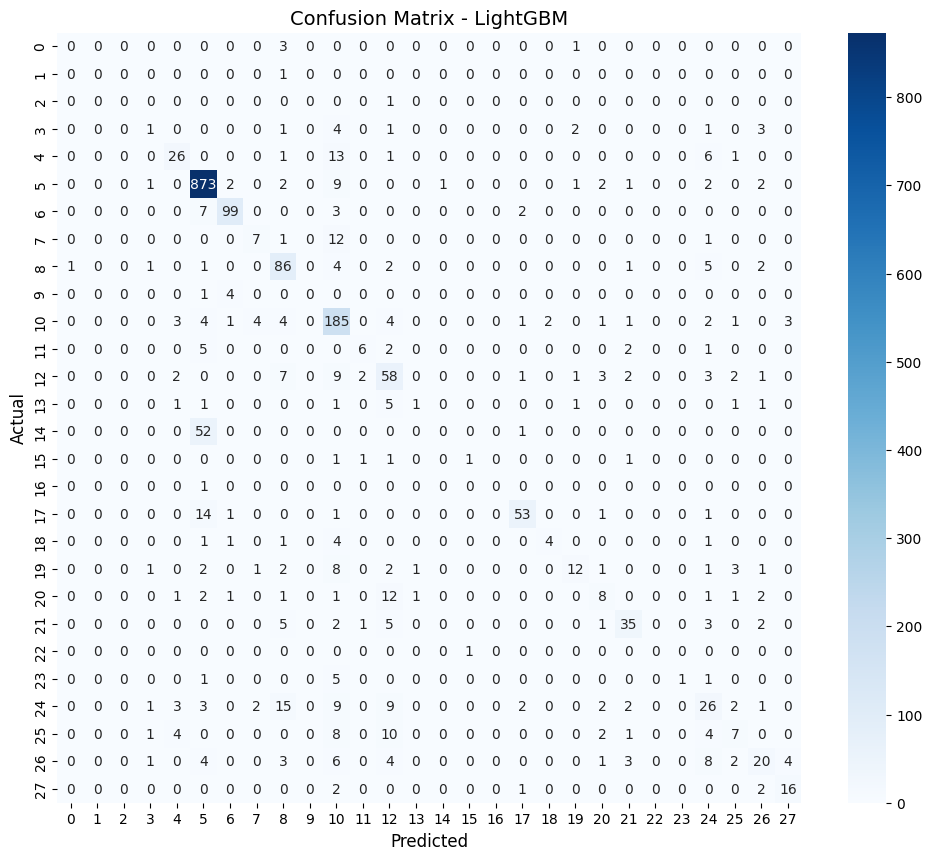

Macro F1: 0.3749
Weighted F1: 0.7364
Minority Class F1: 0.0000

Evaluating Logistic Regression...


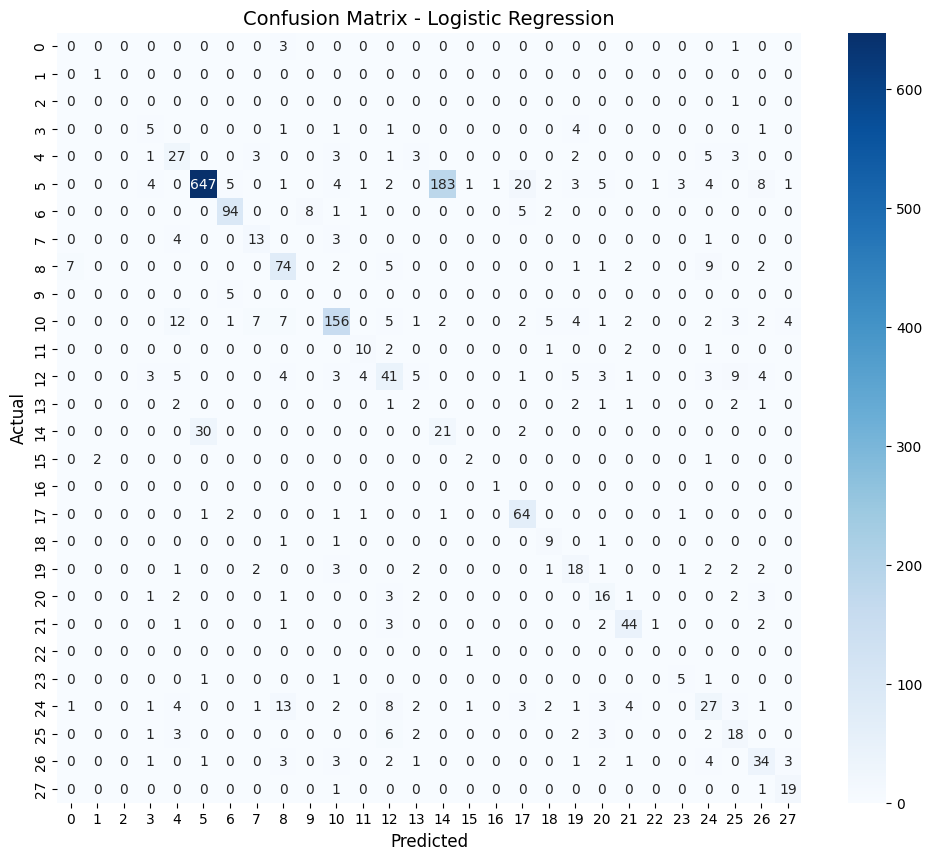

Macro F1: 0.4728
Weighted F1: 0.7054
Minority Class F1: 0.6667

Evaluating MLP...


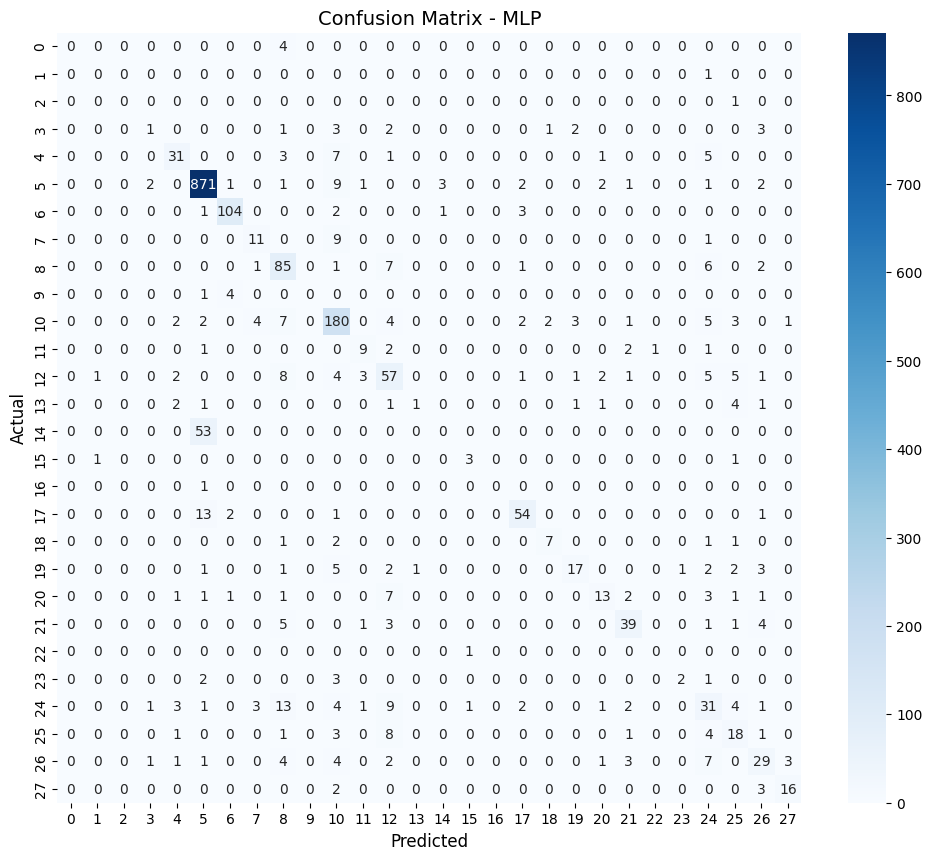

Macro F1: 0.4437
Weighted F1: 0.7717
Minority Class F1: 0.0000


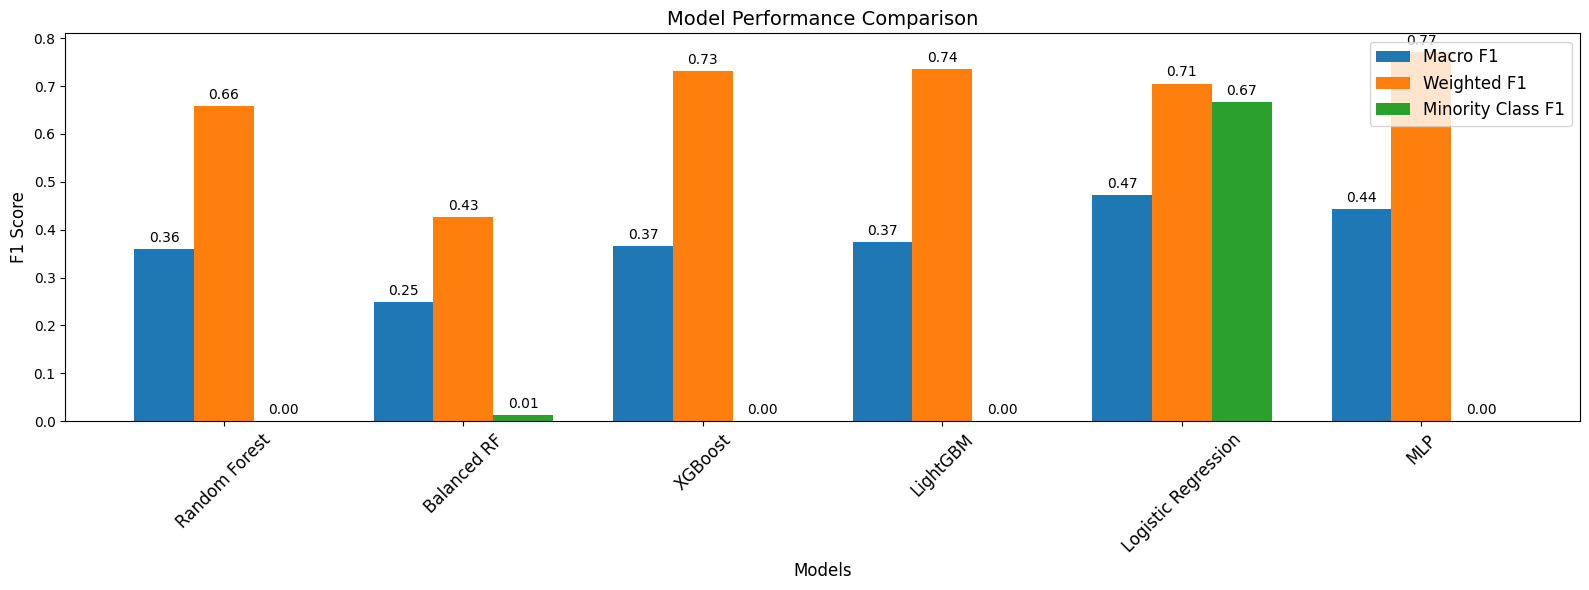

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, log_loss
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Load data function
def load_data():
    X_train = pd.read_csv('X_train.csv')
    y_train = pd.read_csv('y_train.csv')
    X_test_1 = pd.read_csv('X_test_1.csv')
    X_test_2 = pd.read_csv('X_test_2.csv')
    y_test_2_reduced = pd.read_csv('y_test_2_reduced.csv')
    return X_train, y_train, X_test_1, X_test_2, y_test_2_reduced

# Load and prepare data
print("Loading data...")
X_train, y_train, X_test_1, X_test_2, y_test_2_reduced = load_data()
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.values.ravel() if isinstance(y_train, pd.DataFrame) else y_train
X_test_1 = X_test_1.values if isinstance(X_test_1, pd.DataFrame) else X_test_1
X_test_2 = X_test_2.values if isinstance(X_test_2, pd.DataFrame) else X_test_2
y_test_2_reduced = y_test_2_reduced.values.ravel() if isinstance(y_test_2_reduced, pd.DataFrame) else y_test_2_reduced

# Get all classes and class distribution
all_classes = np.unique(y_train)
n_classes = len(all_classes)
class_distribution = pd.Series(y_train).value_counts().sort_index()
minority_class = class_distribution.idxmin()
print("\nClass Distribution:")
print(class_distribution)
print(f"Minority Class: {minority_class}")

# Standardize features
print("\nStandardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_1_scaled = scaler.transform(X_test_1)
X_test_2_scaled = scaler.transform(X_test_2)

# Split data with stratification
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=9417, stratify=y_train)

# Enhanced evaluation function
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Handle probability predictions
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_val)
            if y_proba.shape[1] != n_classes:
                full_proba = np.zeros((len(X_val), n_classes))
                for i, cls in enumerate(model.classes_):
                    cls_idx = np.where(all_classes == cls)[0][0]
                    full_proba[:, cls_idx] = y_proba[:, i]
                y_proba = full_proba
            loss = log_loss(y_val, y_proba, labels=all_classes)
        else:
            y_proba = None
            loss = None

        report = classification_report(y_val, y_pred, output_dict=True, labels=all_classes, zero_division=0)

        # Per-class metrics
        class_metrics = {f"class_{cls}_f1": report[str(cls)]['f1-score'] for cls in all_classes}

        # Confusion matrix
        plt.figure(figsize=(12, 10))
        cm = confusion_matrix(y_val, y_pred, labels=all_classes)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=all_classes, yticklabels=all_classes)
        plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('Actual', fontsize=12)
        plt.show()

        return {
            'model_name': model_name,
            'f1_macro': report['macro avg']['f1-score'],
            'f1_weighted': report['weighted avg']['f1-score'],
            'min_class_f1': report[str(minority_class)]['f1-score'],
            'log_loss': loss,
            'model': model,
            **class_metrics
        }
    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        return None

# =============================================
# Model Implementation and Comparison
# =============================================

print("\n" + "="*50)
print("MODEL COMPARISON".center(50))
print("="*50)

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, random_state=9417,
        class_weight='balanced', max_depth=10
    ),
    'Balanced RF': BalancedRandomForestClassifier(
        n_estimators=200, random_state=9417,
        sampling_strategy='not minority', max_depth=10
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200, random_state=9417,
        eval_metric='mlogloss', scale_pos_weight=1,
        use_label_encoder=False, max_depth=6
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=200, random_state=9417,
        class_weight='balanced', max_depth=6
    ),
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial', solver='lbfgs',
        max_iter=1000, random_state=9417,
        class_weight='balanced', C=0.1
    ),
    'MLP': MLPClassifier(
        hidden_layer_sizes=(128, 64),  # Adjust as needed
        activation='relu',
        solver='adam',
        max_iter=300,
        random_state=9417,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    )
}

results = []
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    result = evaluate_model(model, X_train_split, y_train_split, X_val_split, y_val_split, name)
    if result:
        results.append(result)
        print(f"Macro F1: {result['f1_macro']:.4f}")
        print(f"Weighted F1: {result['f1_weighted']:.4f}")
        print(f"Minority Class F1: {result['min_class_f1']:.4f}")

results_df = pd.DataFrame(results)

# Model Comparison Plot with Separate Bars
plt.figure(figsize=(16, 6))
x = np.arange(len(results_df))
width = 0.25  # Width of each bar

# Create separate bars for each metric
rects1 = plt.bar(x - width, results_df['f1_macro'], width, label='Macro F1', color='#1f77b4')
rects2 = plt.bar(x, results_df['f1_weighted'], width, label='Weighted F1', color='#ff7f0e')
rects3 = plt.bar(x + width, results_df['min_class_f1'], width, label='Minority Class F1', color='#2ca02c')

plt.title('Model Performance Comparison', fontsize=14)
plt.ylabel('F1 Score', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(x, results_df['model_name'], rotation=45, fontsize=12)
plt.legend(fontsize=12)

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()



          IMBALANCE STRATEGY COMPARISON           

Testing strategy: Original

Testing strategy: Class Weight

Testing strategy: Random Oversampling

Testing strategy: SMOTE

Testing strategy: SMOTE + Class Weight


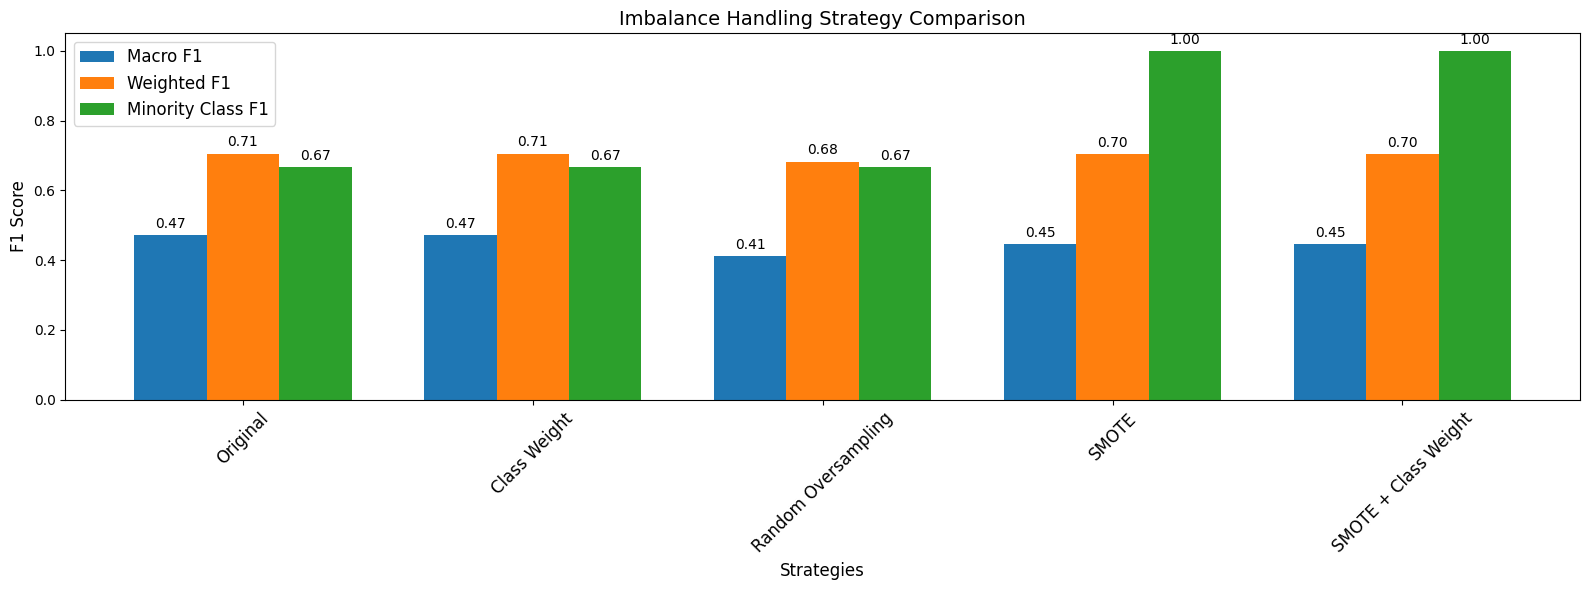

In [13]:
from imblearn.over_sampling import SMOTE
# =============================================
# Imbalance Strategy Comparison
# =============================================

print("\n" + "="*50)
print("IMBALANCE STRATEGY COMPARISON".center(50))
print("="*50)

# Use best performing model as base
best_individual_model_info = results_df.loc[results_df['f1_macro'].idxmax()]
base_model = best_individual_model_info['model']

# Safe SMOTE implementation
min_samples = Counter(y_train_split).most_common()[-1][1]  # Count of rarest class
safe_k = min(5, min_samples - 1) if min_samples > 1 else 1

strategies = {
    'Original': None,
    'Class Weight': 'balanced',
    'Random Oversampling': RandomOverSampler(random_state=9417),
}

# Only add SMOTE strategies if we have enough samples
if min_samples > 1:
    strategies.update({
        'SMOTE': SMOTE(random_state=9417, k_neighbors=safe_k),
        'SMOTE + Class Weight': Pipeline([
            ('smote', SMOTE(random_state=9417, k_neighbors=safe_k)),
            ('model', base_model.__class__(**{**base_model.get_params(), 'class_weight': 'balanced'}))
        ])
    })
else:
    print(f"\nWarning: Skipping SMOTE - minority class has only {min_samples} samples")

strategy_results = []

for strategy_name, strategy in strategies.items():
    print(f"\nTesting strategy: {strategy_name}")

    try:
        if strategy_name == 'Original':
            model = base_model
            X_res, y_res = X_train_split, y_train_split
        elif strategy_name == 'Class Weight':
            model = base_model.__class__(**{**base_model.get_params(), 'class_weight': 'balanced'})
            X_res, y_res = X_train_split, y_train_split
        elif strategy_name == 'SMOTE + Class Weight':
            model = strategy
            X_res, y_res = X_train_split, y_train_split
        else:
            model = base_model
            if strategy:
                X_res, y_res = strategy.fit_resample(X_train_split, y_train_split)
            else:
                X_res, y_res = X_train_split, y_train_split

        model.fit(X_res, y_res)
        y_pred = model.predict(X_val_split)

        report = classification_report(y_val_split, y_pred, output_dict=True, labels=all_classes, zero_division=0)

        strategy_results.append({
            'strategy': strategy_name,
            'f1_macro': report['macro avg']['f1-score'],
            'f1_weighted': report['weighted avg']['f1-score'],
            'min_class_f1': report[str(minority_class)]['f1-score']
        })

    except Exception as e:
        print(f"Error with strategy {strategy_name}: {str(e)}")
        continue

strategy_df = pd.DataFrame(strategy_results)

# Strategy Comparison Plot with Separate Bars
plt.figure(figsize=(16, 6))
if not strategy_df.empty:
    x = np.arange(len(strategy_df))
    width = 0.25

    rects1 = plt.bar(x - width, strategy_df['f1_macro'], width, label='Macro F1', color='#1f77b4')
    rects2 = plt.bar(x, strategy_df['f1_weighted'], width, label='Weighted F1', color='#ff7f0e')
    rects3 = plt.bar(x + width, strategy_df['min_class_f1'], width, label='Minority Class F1', color='#2ca02c')

    plt.title('Imbalance Handling Strategy Comparison', fontsize=14)
    plt.ylabel('F1 Score', fontsize=12)
    plt.xlabel('Strategies', fontsize=12)
    plt.xticks(x, strategy_df['strategy'], rotation=45, fontsize=12)
    plt.legend(fontsize=12)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()
    plt.show()
else:
    print("No valid strategy results to plot")


              ENSEMBLE INVESTIGATION              

Creating ensemble from:
Logistic Regression
                MLP
           LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 300
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training from score -3.332204
[LightGBM] [Info] Start training from score -3.332204
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training from score -3.332204
[LightGBM] [Info] Start training from score -3.332204
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training from score -3.332205
[LightGBM] [Info] Start training 

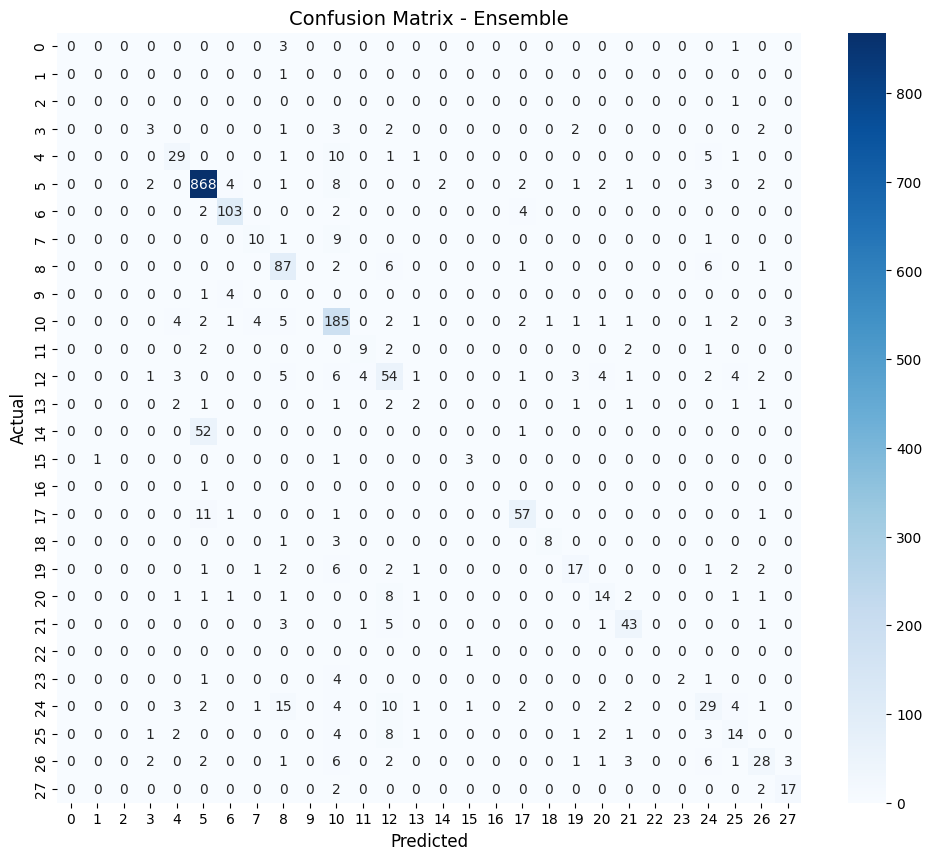


Ensemble Performance:
Macro F1: 0.4544
Weighted F1: 0.7719
Minority Class F1: 0.0000


In [16]:

# =============================================
# Ensemble Investigation
# =============================================

print("\n" + "="*50)
print("ENSEMBLE INVESTIGATION".center(50))
print("="*50)

top_3_models = results_df.nlargest(3, 'f1_macro')
ensemble = VotingClassifier(
    estimators=[(row['model_name'].replace(' ', '_').lower(), row['model'])
               for _, row in top_3_models.iterrows()],
    voting='soft'
)

print("\nCreating ensemble from:")
print(top_3_models['model_name'].to_string(index=False))

ensemble_result = evaluate_model(ensemble, X_train_split, y_train_split, X_val_split, y_val_split, 'Ensemble')
if ensemble_result:
    print("\nEnsemble Performance:")
    print(f"Macro F1: {ensemble_result['f1_macro']:.4f}")
    print(f"Weighted F1: {ensemble_result['f1_weighted']:.4f}")
    print(f"Minority Class F1: {ensemble_result['min_class_f1']:.4f}")


In [17]:

# =============================================
# Final Model Selection
# =============================================

print("\n" + "="*50)
print("FINAL MODEL SELECTION".center(50))
print("="*50)

# Select best individual model (not ensemble)
final_model_info = best_individual_model_info
final_model = final_model_info['model']
final_model_name = final_model_info['model_name']

print(f"\nSelected Model: {final_model_name}")
print(f"Macro F1: {final_model_info['f1_macro']:.4f}")
print(f"Weighted F1: {final_model_info['f1_weighted']:.4f}")
print(f"Minority Class F1: {final_model_info['min_class_f1']:.4f}")
print("\nHyperparameters:")
print(final_model.get_params())

# Train on full data
print("\nTraining on full dataset...")
final_model.fit(X_train_scaled, y_train)



              FINAL MODEL SELECTION               

Selected Model: Logistic Regression
Macro F1: 0.4728
Weighted F1: 0.7054
Minority Class F1: 0.6667

Hyperparameters:
{'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': 9417, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Training on full dataset...


LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=9417)


Generating predictions...
Predictions saved to preds_1.npy and preds_2.npy

           DISTRIBUTION SHIFT ANALYSIS            


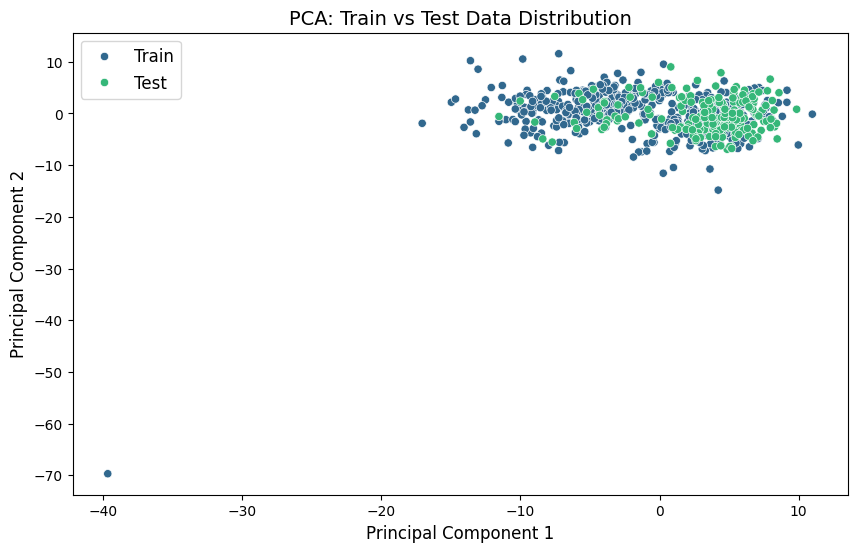


Test Set Performance:
Macro F1: 0.4087
Weighted F1: 0.6296
Minority Class F1: 0.0000


In [18]:

# =============================================
# Prediction Generation
# =============================================

def predict_proba_all_classes(model, X, all_classes):
    proba = model.predict_proba(X)
    if proba.shape[1] != len(all_classes):
        full_proba = np.zeros((len(X), len(all_classes)))
        for i, cls in enumerate(model.classes_):
            cls_idx = np.where(all_classes == cls)[0][0]
            full_proba[:, cls_idx] = proba[:, i]
        return full_proba
    return proba

print("\nGenerating predictions...")
preds1 = predict_proba_all_classes(final_model, X_test_1_scaled, all_classes)
preds2 = predict_proba_all_classes(final_model, X_test_2_scaled, all_classes)

np.save('preds_1.npy', preds1)
np.save('preds_2.npy', preds2)
print("Predictions saved to preds_1.npy and preds_2.npy")

# =============================================
# Distribution Shift Analysis
# =============================================

if len(y_test_2_reduced) > 0:
    print("\n" + "="*50)
    print("DISTRIBUTION SHIFT ANALYSIS".center(50))
    print("="*50)

    # PCA Visualization
    combined = np.vstack([X_train_scaled[:500], X_test_2_scaled[:200]])
    labels = ['Train']*500 + ['Test']*200

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=labels, palette='viridis')
    plt.title('PCA: Train vs Test Data Distribution', fontsize=14)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend(fontsize=12)
    plt.show()

    # Evaluate on test data
    test_pred = final_model.predict(X_test_2_scaled[:len(y_test_2_reduced)])
    test_report = classification_report(y_test_2_reduced, test_pred,
                                      labels=all_classes, zero_division=0, output_dict=True)

    print("\nTest Set Performance:")
    print(f"Macro F1: {test_report['macro avg']['f1-score']:.4f}")
    print(f"Weighted F1: {test_report['weighted avg']['f1-score']:.4f}")
    print(f"Minority Class F1: {test_report[str(minority_class)]['f1-score']:.4f}")

In [19]:
# Compare model performance
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['model_name', 'f1_macro', 'f1_weighted', 'min_class_f1']])



Model Comparison:
            model_name  f1_macro  f1_weighted  min_class_f1
0        Random Forest  0.358961     0.658802      0.000000
1          Balanced RF  0.247969     0.426131      0.012658
2              XGBoost  0.366512     0.730776      0.000000
3             LightGBM  0.374872     0.736424      0.000000
4  Logistic Regression  0.472765     0.705417      0.666667
5                  MLP  0.443666     0.771720      0.000000
